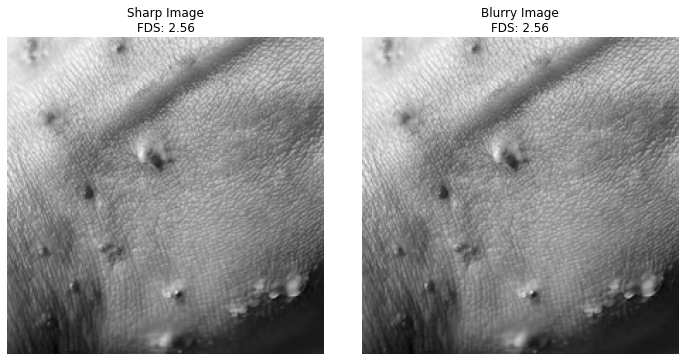

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.morphology import skeletonize
from skimage.filters import sobel
from skimage.measure import label, regionprops

def compute_focus_degradation_score(image_gray):
    # Use Sobel to get edge magnitude
    edge_mag = sobel(image_gray)

    # Threshold to get binary edge map
    edge_thresh = edge_mag > 0.1  # you may tune this threshold
    edge_skeleton = skeletonize(edge_thresh)  # Thins edges to 1-pixel wide

    # Label connected components in original edge map
    labeled_edges = label(edge_thresh)
    widths = []

    for region in regionprops(labeled_edges):
        coords = region.coords
        # Compute width as the maximum distance between pixels in the same component
        if len(coords) > 1:
            distances = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=2)
            max_width = np.max(distances)
            widths.append(max_width)

    # If no edges found, return maximum blur score
    if not widths:
        return 10.0

    avg_edge_width = np.mean(widths)

    # Normalize edge width to scale 1 (sharp) to 10 (blurry)
    # Assume edge widths between 1 and 10 for scaling; you may calibrate based on use case
    fds = np.clip((avg_edge_width - 1) / 9 * 9 + 1, 1, 10)
    return round(fds, 2)

def make_blurry(image, sigma=0.9):
    return gaussian_filter(image, sigma=sigma)

# Load and preprocess image
image_path = 'MP_4.png'  # Replace with your image path
original = cv2.imread(image_path)
original = cv2.resize(original, (224, 224))
gray_original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY) / 255.0

# Create blurry image
gray_blurry = make_blurry(gray_original)

# Compute FDS
fds_original = compute_focus_degradation_score(gray_original)
fds_blurry = compute_focus_degradation_score(gray_blurry)

# Display results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(gray_original, cmap='gray')
axs[0].set_title(f'Sharp Image\nFDS: {fds_original}')
axs[0].axis('off')

axs[1].imshow(gray_blurry, cmap='gray')
axs[1].set_title(f'Blurry Image\nFDS: {fds_blurry}')
axs[1].axis('off')

plt.tight_layout()
plt.show()
